In [1]:
import os
os.environ['OMP_NUM_THREADS'] = '1'

from tqdm.auto import tqdm
from multiprocessing import Pool

import numpy as np
from scipy import optimize
from matplotlib import pyplot as plt

import noctiluca as nl
import bayesmsd

In [2]:
saved = nl.io.load.hdf5('../../data/20250302_minflux_raw.h5')

In [3]:
data       = saved['data']
conditions = saved['conditions']
data.makeSelection()

In [4]:
conditions = sorted([cond for cond in conditions if 'array' not in cond])
data.makeSelection(conditions, logic=any)
data = data.copySelection()

In [5]:
# Ultimately we will discard any (filtered & cut) trajectory shorter
# than 1K frames, so might as well do it here also, for convenience
data.makeSelection(lambda traj, _: traj.F < 1000)
data.deleteSelection()

print(len(data), 'trajectories')

8637 trajectories


# Plot MSDs

H2B, U2OS, DRB 1445


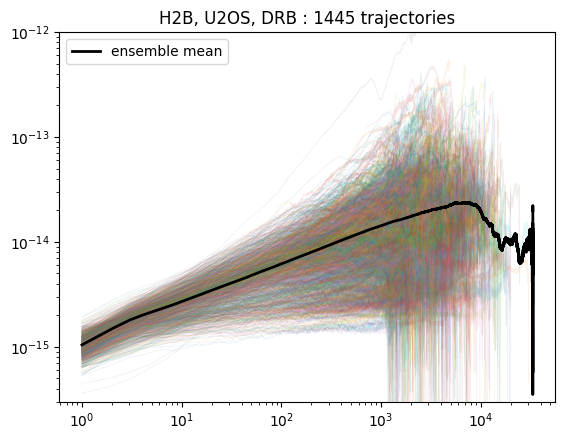

H2B, U2OS, ICRF 1553


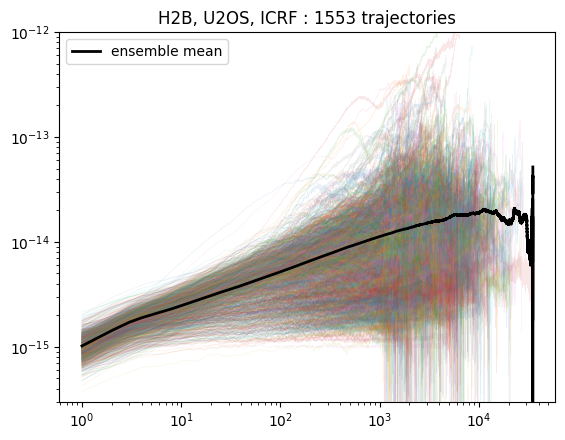

H2B, U2OS, TSA 1536


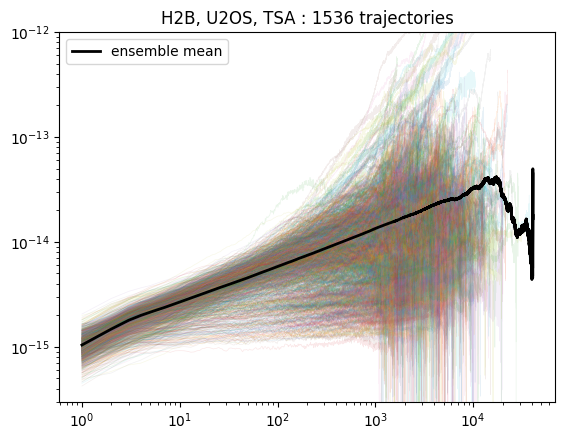

H2B, U2OS, ctrl 1691


/home/sgh/projects/Hansenlab/2025-05_minflux_for_repo/pyenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


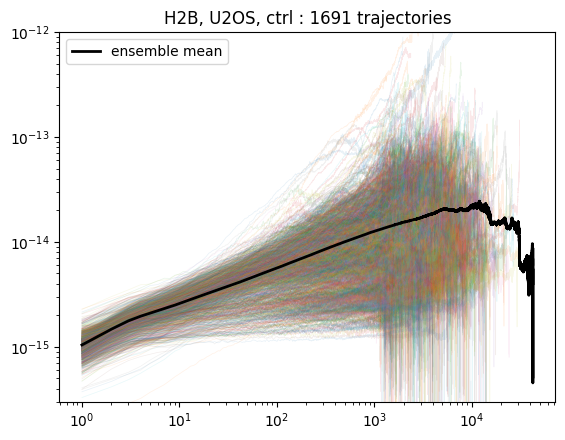

H2B, mESC, DRB 560


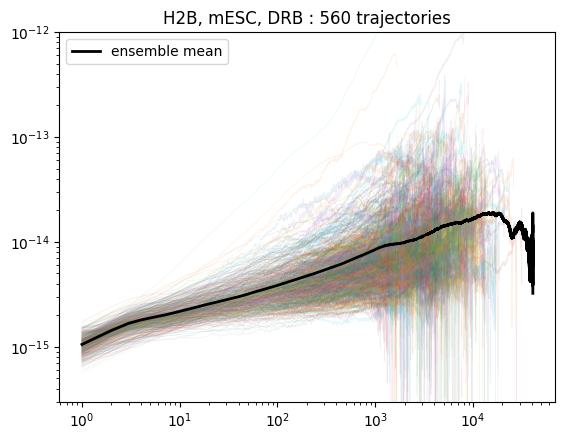

H2B, mESC, ICRF 621


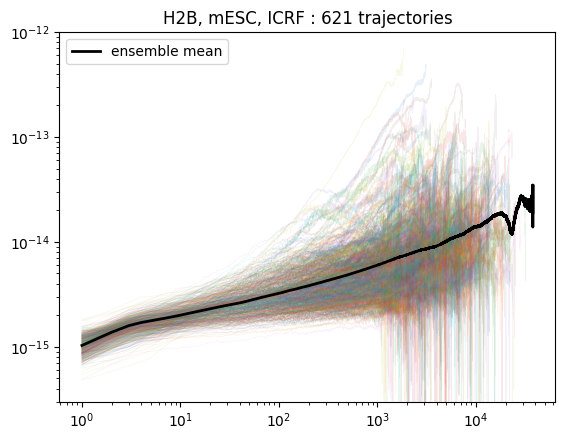

H2B, mESC, TSA 523


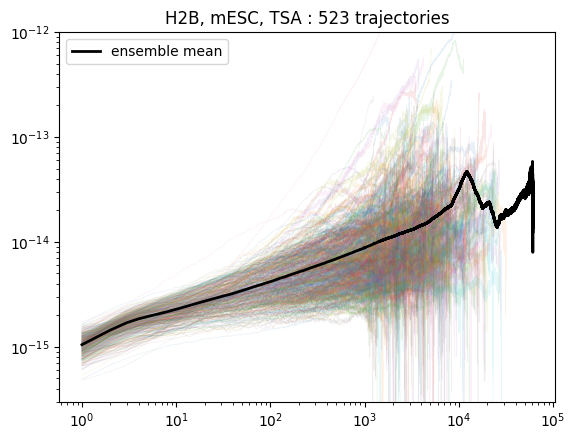

H2B, mESC, ctrl 708


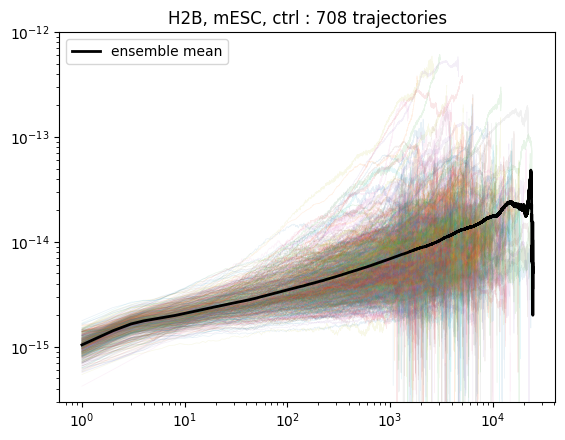

In [6]:
for cond in conditions:
    data.makeSelection(cond)
    print(cond, len(data))

    nl.plot.msd_overview(data, linewidth=0.5, alpha=0.1)
    plt.title(f'{cond} : {len(data)} trajectories')
    plt.ylim([3e-16, 1e-12])
    plt.show()

# Filtering background trajectories
Copied from array cleaning; there's not much background here for the most part, so this doesn't do too much. Still a good idea to chop off the odd ends and kick out the few background traces that there are.

In [7]:
# Technical check, since we assume below that first and last frame are valid
data.makeSelection()
for traj in data:
    assert not np.any(np.isnan(traj[[0, -1]]))

In [8]:
plotting = False # set to True for plotting

data_valid = nl.TaggedSet()

data.makeSelection()
filetags = sorted({tag for tag in data.tagset() if tag.startswith('file=')})
for tag in tqdm(filetags):
    data.makeSelection(tag)
    
    if plotting:
        fig, axs = plt.subplots(1, 2, figsize=[10, 4],
                                gridspec_kw={'width_ratios' : [4, 6]},
                               )
    
        t0 = 0
        off_x, off_y = data[0][0]
        off_y += 1e-6 # get an offset between the coordinates
        
    for i, (traj, tags) in enumerate(data(giveTags=True)):
        # Cut off background
        i_valid = np.nonzero(~np.isnan(traj.abs()[:]))[0]
        frames = traj[i_valid]
        med = np.median(frames, axis=0)
        above = frames > med[None, :]
        ind_crossing_x = np.nonzero(np.diff(above[:, 0]))[0]
        ind_crossing_y = np.nonzero(np.diff(above[:, 1]))[0]
        
        ind_start = max(ind_crossing_x[ 0]+1, ind_crossing_y[ 0]+1)
        ind_end   = min(ind_crossing_x[-1],   ind_crossing_y[-1]) #- len(frames)
        if ind_end > ind_start:
            t_start = i_valid[ind_start]
            t_end   = i_valid[ind_end  ]+1
            traj_valid = nl.Trajectory(traj[t_start:t_end], dt=traj.meta['dt'])
        else:
            traj_valid = None
        
        if traj_valid is not None:
            data_valid.add(traj_valid, tags)
        
        if plotting:
            ax = axs[0]
            nl.plot.spatial(traj, ax=ax, color='gray', alpha=0.5)# label=f'{i} | ')
            if traj_valid is not None:
                nl.plot.spatial(traj_valid, ax=ax, label=f'{i} | ')

            ax = axs[1]
            ind_valid = np.nonzero(~np.isnan(traj.abs()[:][:, 0]))[0]
            h = ax.plot(t0 + ind_valid, traj[ind_valid][:, 0] - off_x, color='gray', alpha=0.5)
            h = ax.plot(t0 + ind_valid, traj[ind_valid][:, 1] - off_y,
                        color=h[0].get_color(), alpha=0.5,
                       )
            if traj_valid is not None:
                ind = np.nonzero(~np.isnan(traj_valid.abs()[:][:, 0]))[0]
                h = ax.plot(t0 + t_start + ind, traj_valid[ind][:, 0] - off_x)
                h = ax.plot(t0 + t_start + ind, traj_valid[ind][:, 1] - off_y,
                            color=h[0].get_color(),
                           )

            t0 += ind_valid[-1] + 1

    if plotting:
        ax = axs[0]
        ax.axis('square')

        plt.show()

  0%|          | 0/324 [00:00<?, ?it/s]

In [9]:
data_valid.makeSelection(lambda traj, _: traj.F < 1000)
data_valid.deleteSelection()
print(len(data_valid), 'valid trajectories')

with nl.Parallelize():
    _ = nl.analysis.MSD(data_valid, chunksize=1, show_progress=True)

7849 valid trajectories


  0%|          | 0/7849 [00:00<?, ?it/s]

H2B, U2OS, DRB 1303


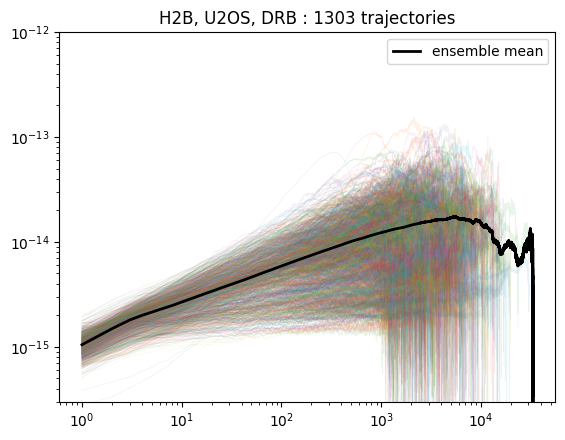

H2B, U2OS, ICRF 1395


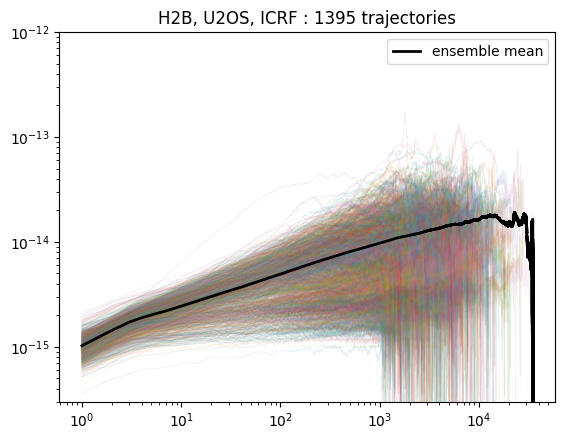

H2B, U2OS, TSA 1373


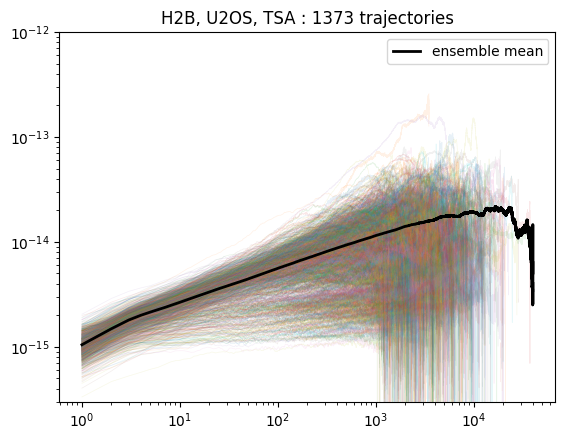

H2B, U2OS, ctrl 1517


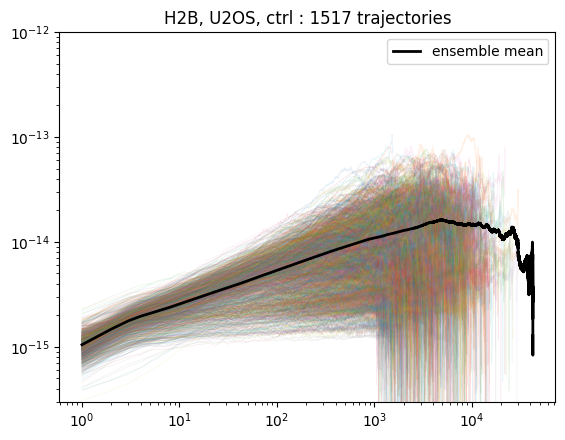

H2B, mESC, DRB 525


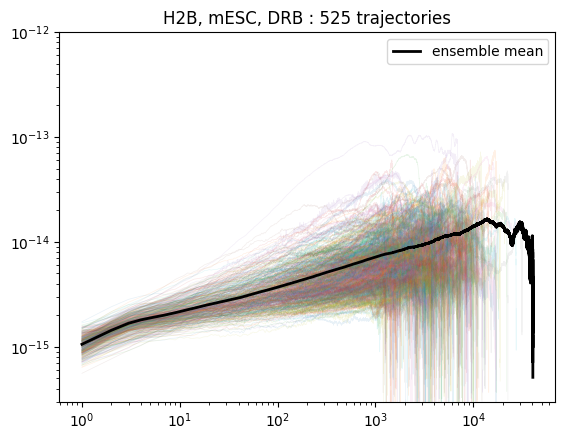

H2B, mESC, ICRF 585


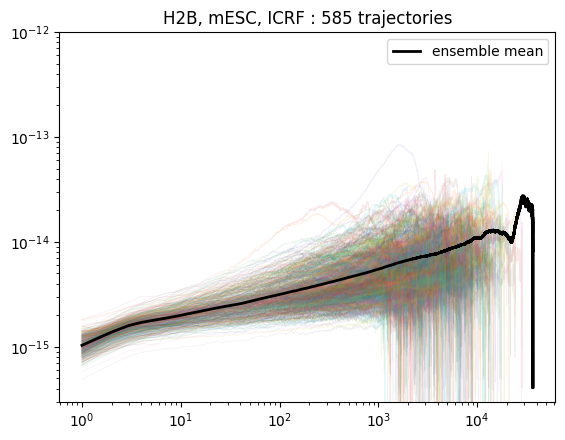

H2B, mESC, TSA 485


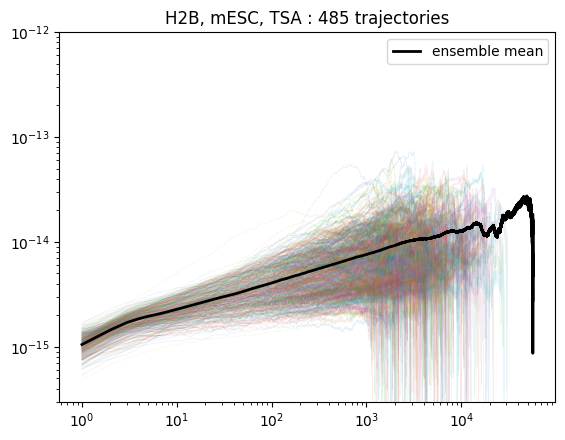

H2B, mESC, ctrl 666


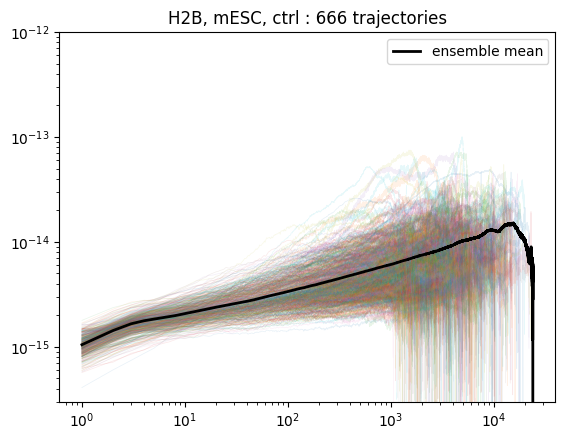

In [10]:
for cond in conditions:
    data_valid.makeSelection(cond)
    print(cond, len(data_valid))

    nl.plot.msd_overview(data_valid, linewidth=0.5, alpha=0.1)
    plt.title(f'{cond} : {len(data_valid)} trajectories')
    plt.ylim([3e-16, 1e-12])
    plt.show()

H2B, U2OS, DRB: 1303 trajectories
H2B, U2OS, ICRF: 1395 trajectories
H2B, U2OS, TSA: 1373 trajectories
H2B, U2OS, ctrl: 1517 trajectories
H2B, mESC, DRB: 525 trajectories
H2B, mESC, ICRF: 585 trajectories
H2B, mESC, TSA: 485 trajectories
H2B, mESC, ctrl: 666 trajectories


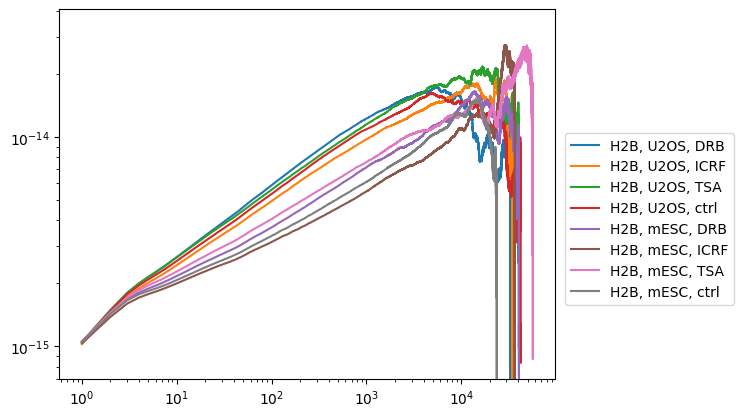

In [11]:
for cond in conditions:
    data_valid.makeSelection(cond)
    print(f'{cond:>5s}: {len(data_valid):>3d} trajectories')
    
    msd = nl.analysis.MSD(data_valid)
    plt.plot(np.arange(1, len(msd)), msd[1:], label=cond)
    
plt.legend(loc=(1.02, 0.2))
plt.xscale('log')
plt.yscale('log')
plt.ylim([7e-16, None])
plt.show()

In [13]:
nl.io.write.hdf5({
    'data' : data_valid,
    'conditions' : conditions,
    'description' : """
Cleaned-up MINFLUX H2B data

Cleaning was done by cutting before the first and after the last median-crossing

Conditions are:
 - H2B, mESC, ctrl
 - H2B, mESC, DRB
 - H2B, mESC, TSA
 - H2B, mESC, ICRF
 - H2B, U2OS, ctrl
 - H2B, U2OS, DRB
 - H2B, U2OS, TSA
 - H2B, U2OS, ICRF
"""[1:-1]}, '../../data/20250302_minflux_H2B_clean.h5')